# In this notebook the VeRoLog instance files are translated into the variables used in the MILP

## Imports

In [40]:
import math as math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from networkx import nx
import csv as csv
import logging
logging.basicConfig(filename='VeRoLog MILP', level=logging.INFO,format='%(asctime)s:%(levelname)s:%(message)s')

## Load file

In [2]:
data= pd.read_csv("VSC2019_ORTEC_Example.csv", sep=";", header=None)

In [3]:
data.head(15)

,0,1,2,3,4,5,6,7
0,DATASET,=,VeRoLog,solver,challenge,2019.0,NaN,NaN
1,NAME,=,testInstance,NaN,NaN,NaN,NaN,NaN
2,DAYS,=,7,NaN,NaN,NaN,NaN,NaN
3,TRUCK_CAPACITY,=,6,NaN,NaN,NaN,NaN,NaN
4,TRUCK_MAX_DISTANCE,=,250,NaN,NaN,NaN,NaN,NaN
5,TRUCK_DISTANCE_COST,=,1,NaN,NaN,NaN,NaN,NaN
6,TRUCK_DAY_COST,=,100,NaN,NaN,NaN,NaN,NaN
7,TRUCK_COST,=,100000,NaN,NaN,NaN,NaN,NaN
8,TECHNICIAN_DISTANCE_COST,=,1,NaN,NaN,NaN,NaN,NaN
9,TECHNICIAN_DAY_COST,=,100000,NaN,NaN,NaN,NaN,NaN


### First the integer values, which are relatively easy to get

In [20]:
trucks = [i for i in range(3)]  #(arbitrarily chosen)
DAYS = int(data[data[0] == "DAYS"][2].values[0])
TRUCK_DISTANCE_COST = int(data[data[0] == "TRUCK_DISTANCE_COST"][2].values[0])
TRUCK_DAY_COST = int(data[data[0] == "TRUCK_DAY_COST"][2].values[0])
TRUCK_COST = int(data[data[0] == "TRUCK_COST"][2].values[0])
TECHNICIAN_DISTANCE_COST = int(data[data[0] == "TECHNICIAN_DISTANCE_COST"][2].values[0])
TECHNICIAN_DAY_COST = int(data[data[0] == "TECHNICIAN_DAY_COST"][2].values[0])
TECHNICIAN_COST = int(data[data[0] == "TECHNICIAN_COST"][2].values[0])
TRUCK_MAX_DISTANCE = int(data[data[0] == "TRUCK_MAX_DISTANCE"][2].values[0])
TRUCK_CAPACITY = int(data[data[0] == "TRUCK_CAPACITY"][2].values[0])
LARGE_NUMBER = 1000

### Now the input parameters

In [21]:
def get_indexes(data):
    """
    Purpose
        Get some important indexes that are important to navigate through data
    Input
        data, dataframe: data of the instance
    Output
        total_requests, int: total number of requests in data
        total_technicians, int: total number of technicians in data
        locations_index, int: index of locations in data
        requests_index, int: index of requests in data
        technicians_index, int: index of technicians in data
        total_machines, int: total number of machines in data
        machines_index, int: index of machines in data
    """
    total_requests = int(data[data[0] == "REQUESTS"][2].values[0])
    total_technicians = int(data[data[0] == "TECHNICIANS"][2].values[0])
    locations_index = data[data[0] == "LOCATIONS"].index.values[0]
    requests_index = data[data[0] == "REQUESTS"].index.values[0]
    technicians_index = data[data[0] == "TECHNICIANS"].index.values[0]
    
    total_machines = int(data[data[0] == "MACHINES"][2].values[0])
    machines_index = data[data[0] == "MACHINES"].index.values[0]
    
    return total_requests,total_technicians,locations_index,requests_index,technicians_index,total_machines,machines_index
total_requests,total_technicians,locations_index,requests_index,technicians_index,total_machines,machines_index = get_indexes(data)

In [22]:
def get_machine_data(data,total_machines,machines_index):
    """
    Purpose
        Get machine related data
    Input
        data, dataframe: data of the instance
        total_machines, int: total number of machines in data
        machines_index, int: index of machines in data
    Output
        machines, list: machines in the problem
        machine_size, list: size of each machine
        machine_penalty, list: daily penalty for idle machines (delivered but not yet installed)
    """
    machines = [m for m in range(total_machines)]
    machine_size = []
    machine_penalty = []
    for i in range(machines_index,machines_index+total_machines):
        machine_size.append(int(data.loc[i+1][1])) #column 1 specifies the size of the machine
        machine_penalty.append(int(data.loc[i+1][2])) #column 2 specifies the penalty
    
    return machines,machine_size,machine_penalty
machines,machine_size,machine_penalty = get_machine_data(data,total_machines,machines_index)

In [23]:
def get_customer_data(data,total_requests,requests_index):
    """
    Purpose
        Get customer related data
    Input
        data, dataframe: data of the instance
        total_requests, int: total number of requests in data
        requests_index, int: index of requests in data
    Output
        customers, list: customers in the problem
        start_delivery_window, list: start of the delivery window for each customer
        end_delivery_window, list: end of the delivery window for each customer
        customer_machine_types, list: machine type of each customer order/request
        customer_order_size, list: size of each customer order/request       
    """
    customers = [c for c in range(total_requests)]
    start_delivery_window = []
    end_delivery_window = []
    customer_machine_types = []
    customer_order_size = []
    for i in range(requests_index,requests_index+total_requests):
        start_delivery_window.append(int(data.loc[i+1][2])-1) #column 2 is the first delivery day
        end_delivery_window.append(int(data.loc[i+1][3])-1) #column 3 is the last delivery day
        customer_machine_types.append(int(data.loc[i+1][4])-1) #column 4 is the machine type
        customer_order_size.append(int(data.loc[i+1][5])) #column 5 is the order size    
        
    return customers,start_delivery_window,end_delivery_window,customer_machine_types,customer_order_size
customers,start_delivery_window,end_delivery_window,customer_machine_types,customer_order_size = get_customer_data(data,total_requests,requests_index)

In [43]:
def get_technician_data(data,total_technicians,technicians_index,total_machines):
    """
    Purpose
        Get technician related data
    Input
        data, dataframe: data of the instance
        total_machines, int: total number of technicians in data
        technicians_index, int: index of technicians in data
        total_machines, int: total number of machines in data
    Output
        technicians, list: technicians in the problem
        technician_max_distance, list: maximum distance each technician can drive daily
        technician_max_visits, list: maximum number of customers each technician can visit daily
        technician_skill_set, list: skill set dummy that indicates if a technician can install a machine
    """
    technicians = [h for h in range(total_technicians)]
    technician_max_distance = []
    technician_max_visits = []
    technician_skill_set = []
    for i in range(technicians_index,technicians_index+total_technicians):
        technician_max_distance.append(int(data.loc[i+1][2])) #column 2 specifies the max distance
        technician_max_visits.append(int(data.loc[i+1][3])) #column 3 denotes the max number of requests
        technician_skill_set.append([])
        for j in range(total_machines): #Remainign entries specify the technician skillset
            technician_skill_set[i-technicians_index].append(int(data.loc[i+1][j+4]))    
    
    return technicians,technician_max_distance,technician_max_visits,technician_skill_set
technicians,technician_max_distance,technician_max_visits,technician_skill_set = get_technician_data(data,total_technicians,technicians_index,total_machines)

### Get the graph input

In [25]:
def get_nodes(data,total_requests,total_technicians,locations_index,requests_index,technicians_index):
    """
    Purpose
        Get all nodes needed for the problem
    Input
        data, dataframe: data of the instance
        total_requests, int: total number of requests in data
        total_technicians, int: total number of technicians in data
        locations_index, int: index of locations in data
        requests_index, int: index of requests in data
        technicians_index, int: index of technicians in data
    Output
        depot_node, dict: node (key) and coordinates (value) of the depot
        customer_nodes, dict: nodes (keys) and coordinates (values) of the customers
        technician_nodes, dict: nodes (keys) and coordinates (values) of the technicians
        nodes, dict: nodes (keys) and coordinates (values) of all nodes in the problem
        x_nodes, dict: nodes (keys) and coordinates (values) related to x variable in the mathematical problem
    """
    #column 1 is the x coordinate, column 2 the y coordinate
    depot_node = {0:(int(data.loc[locations_index+1][1]),int(data.loc[locations_index+1][2]))}
    
    customer_nodes = {}
    for i in range(requests_index,requests_index+total_requests):
        locationid = int(data.loc[i+1][1]) #column 1 is the request location
        #customer node numbering starts at 1
        customer_nodes[i-requests_index+1] = (int(data.loc[locations_index+locationid][1]),int(data[2][locations_index+locationid]))
    
    technician_nodes = {}
    for i in range(technicians_index,technicians_index+total_technicians):
        locationid = int(data.loc[i+1][1])
        #technician node numbering starts at total_requests+1
        technician_nodes[i-technicians_index+total_requests+1] =  (int(data.loc[locations_index+locationid][1]),int(data[2][locations_index+locationid]))
    
    nodes = {**depot_node,**customer_nodes,**technician_nodes}
    x_nodes = {**depot_node,**customer_nodes} 
    
    return depot_node,customer_nodes,technician_nodes,nodes,x_nodes
depot_node,customer_nodes,technician_nodes,nodes,x_nodes = get_nodes(data,total_requests,total_technicians,
                                                                     locations_index,requests_index,technicians_index)

In [26]:
def tech_graph(h,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types):
    """
    Purpose,
        Create a graph that includes the technician node and all the customer location where the technician can install
    Input,
        h, int: technician under consideration
        technician_skill_set, list: the skillset of each technician
        technician_nodes, dict: nodes of technicians
        customer_nodes, dict: nodes of customers
        customer_machine_types, list: machine type of each customer order/request
    Output,
        G_tech_h, networkx DiGraph for technician h
    """
    G_tech_h = nx.DiGraph()
    G_tech_h.add_nodes_from({key: technician_nodes[key] for key in [len(customer_nodes)+1+h]})
    
    customers_to_add = []
    for i in customer_nodes:
        if technician_skill_set[h][customer_machine_types[i-1]]:
            customers_to_add.append(i)
    
    G_tech_h.add_nodes_from({key: customer_nodes[key] for key in customers_to_add})
    
    return G_tech_h

In [44]:
def get_edges_cost(nodes,x_nodes,technician_skill_set,technician_nodes,customer_nodes,technicians,customer_machine_types):
    """
    Purpose
        Get the edge cost in the problem (ceiling of the euclidean distance between the coordinates), the index of each edge 
        in cost_edges is returned as well in a dictionary. Note that the graph is directed. We have edges that connect the
        depot to each customer and each customer to each customer. We have edges that connect the technician home locations 
        to each customer where the technician can install. The cost for travelling over edge i is found 
        by cost_edges[edges_index[i][0]][edges_index[i][1]].
    Input
        nodes, dict: nodes (keys) and coordinates (values) of all nodes in the problem
        x_nodes, dict: nodes (keys) and coordinates (values) related to x variable in the mathematical problem
        technician_skill_set, list: the skillset of each technician
        technician_nodes, dict: nodes of technicians
        customer_nodes, dict: nodes of customers
        technicians, list: technicians in the problem
        customer_machine_types, list: machine type of each customer order/request        
    Output
        cost_edges, list: containing the cost for each edge 
        edges_index, dict: containing the index in cost_edges (values) for each edge (keys)
    """
    # we first want the edges that connect the depot to each customer and each customer to each customer
    count_0 = 0
    count_1 = 0    
    edges_index = {}
    cost_edges = [[] for i in nodes]
    for i in x_nodes:
        count_1 = 0
        for j in x_nodes:
            if i!=j:
                edges_index[(i,j)] = (count_0,count_1)
                cost_edges[i].append(math.ceil(math.sqrt((x_nodes[i][0] - x_nodes[j][0])**2+(x_nodes[i][1]-x_nodes[j][1])**2)))
                count_1 +=1
        count_0 +=1
        
    # we now want to connect the technician home locations to each customer where it can install
    for h in technicians:
        tech_node = h+len(customer_nodes)+1
        G_tech_h = tech_graph(h,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types)
        G_tech_h.remove_node(tech_node)
        count_1 = 0
        for cust_node in G_tech_h.nodes:
            edges_index[(tech_node,cust_node)] = (count_0,count_1)
            edges_index[(cust_node,tech_node)] = (count_0,count_1+1)
            cost_edges[tech_node].append(math.ceil(math.sqrt((technician_nodes[tech_node][0]-customer_nodes[cust_node][0])**2+(technician_nodes[tech_node][1]-customer_nodes[cust_node][1])**2)))
            cost_edges[tech_node].append(math.ceil(math.sqrt((customer_nodes[cust_node][0]-technician_nodes[tech_node][0])**2+(customer_nodes[cust_node][1]-technician_nodes[tech_node][1])**2)))
            count_1 += 2
        count_0 +=1
    return cost_edges,edges_index

cost_edges,edges_index = get_edges_cost(nodes,x_nodes,technician_skill_set,technician_nodes,customer_nodes,technicians,customer_machine_types) 

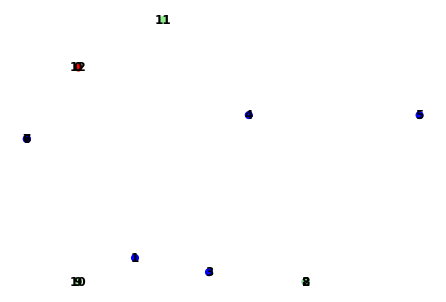

In [28]:
#create and plot the graph with networkx
G_cust = nx.DiGraph()
G_tech = nx.DiGraph()
G_depot = nx.DiGraph()

G_cust.add_nodes_from(customer_nodes)
G_tech.add_nodes_from(technician_nodes)
G_depot.add_nodes_from(depot_node)

pos = {}
for node in G_cust.nodes:
    pos[node] = nodes[node]
for node in G_tech.nodes:
    pos[node] = nodes[node]
for node in G_depot.nodes:
    pos[node] = nodes[node]
    
plt.figure(figsize=[6,4])
nx.draw(G_cust,pos=pos, node_size=50, with_labels=True, font_weight='bold',node_color=["blue" for c in customers])
nx.draw(G_tech,pos=pos, node_size=50, with_labels=True, font_weight='bold',node_color=["lightgreen" for tech in technicians])
nx.draw(G_depot,pos=pos,node_size=50, with_labels=True, font_weight='bold',node_color=['red'])
plt.show()

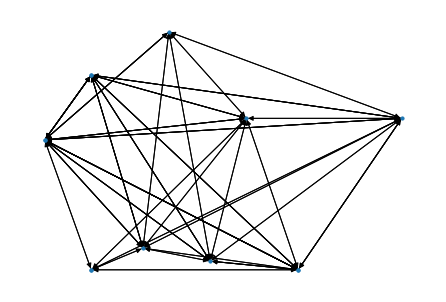

In [29]:
#with edges
G = nx.DiGraph()
for k,v in edges_index.items():
    G.add_edge(*k)
    
plt.figure(figsize=[6,4])
nx.draw(G,pos=pos, node_size=10)
plt.show()

In [30]:
print(DAYS)
print(technicians)
print(trucks)
print(machines)
print(customers)

print(customer_machine_types)
print(machine_size)
print(machine_penalty)
print(customer_order_size)
print(start_delivery_window)
print(end_delivery_window)
print(technician_max_visits)
print(technician_max_distance)
print(technician_skill_set)
print(TRUCK_MAX_DISTANCE)
print(TRUCK_CAPACITY)
print(LARGE_NUMBER)

print(TRUCK_DISTANCE_COST)
print(TRUCK_DAY_COST)
print(TRUCK_COST)
print(TECHNICIAN_DISTANCE_COST)
print(TECHNICIAN_DAY_COST)
print(TECHNICIAN_COST)

7
[0, 1, 2, 3, 4]
[0, 1, 2]
[0, 1, 2, 3]
[0, 1, 2, 3, 4, 5, 6]
[0, 2, 3, 0, 1, 3, 1]
[2, 1, 3, 2]
[200, 200, 500, 100]
[1, 1, 2, 3, 1, 1, 4]
[0, 2, 1, 4, 0, 0, 2]
[6, 5, 2, 6, 3, 5, 4]
[2, 1, 5, 2, 1]
[100, 100, 100, 100, 50]
[[0, 1, 1, 1], [1, 1, 0, 0], [0, 0, 1, 0], [1, 1, 0, 1], [1, 1, 1, 1]]
250
6
1000
1
100
100000
1
100000
100


In [32]:
print(depot_node)
print(customer_nodes)
print(technician_nodes)
print(nodes)
print(x_nodes)
print(edges_index)
print(cost_edges)

{0: (10, 50)}
{1: (20, 10), 2: (50, 5), 3: (33, 7), 4: (40, 40), 5: (70, 40), 6: (1, 35), 7: (1, 35)}
{8: (50, 5), 9: (10, 5), 10: (10, 5), 11: (25, 60), 12: (10, 50)}
{0: (10, 50), 1: (20, 10), 2: (50, 5), 3: (33, 7), 4: (40, 40), 5: (70, 40), 6: (1, 35), 7: (1, 35), 8: (50, 5), 9: (10, 5), 10: (10, 5), 11: (25, 60), 12: (10, 50)}
{0: (10, 50), 1: (20, 10), 2: (50, 5), 3: (33, 7), 4: (40, 40), 5: (70, 40), 6: (1, 35), 7: (1, 35)}
{(0, 1): (0, 0), (0, 2): (0, 1), (0, 3): (0, 2), (0, 4): (0, 3), (0, 5): (0, 4), (0, 6): (0, 5), (0, 7): (0, 6), (1, 0): (1, 0), (1, 2): (1, 1), (1, 3): (1, 2), (1, 4): (1, 3), (1, 5): (1, 4), (1, 6): (1, 5), (1, 7): (1, 6), (2, 0): (2, 0), (2, 1): (2, 1), (2, 3): (2, 2), (2, 4): (2, 3), (2, 5): (2, 4), (2, 6): (2, 5), (2, 7): (2, 6), (3, 0): (3, 0), (3, 1): (3, 1), (3, 2): (3, 2), (3, 4): (3, 3), (3, 5): (3, 4), (3, 6): (3, 5), (3, 7): (3, 6), (4, 0): (4, 0), (4, 1): (4, 1), (4, 2): (4, 2), (4, 3): (4, 3), (4, 5): (4, 4), (4, 6): (4, 5), (4, 7): (4, 6), (5, 

In [37]:
def data_checks(technicians,customers,machines,technician_nodes,customer_nodes,technician_max_visits,
               technician_max_distance,technician_skill_set,customer_machine_types,customer_order_size,
               start_delivery_window,end_delivery_window,machine_size,machine_penalty,
                TRUCK_MAX_DISTANCE,TRUCK_CAPACITY,DAYS,edges_index,cost_edges):
    """
    Purpose:
        Some checks to see if the data has been succesfully read from the file
    Input:
        technicians, list: the set of technicians
        customers, list: the set of customers
        machines, list: the set of machines
        technician_nodes, dict: the set of technician nodes
        customer_nodes, list: the set of customer nodes
        technician_max_visits, list: the set of maximum vistis for each technician
        technician_max_distance, list: the set of maximum distance for each technician
        technician_skill_set, list of lists: the set of skill set dummies for each technician and machinetype
        customer_machine_types, list: the set of machine types ordered for each customer
        customer_order_size, list: the set of quantities ordered by each customer
        start_delivery_window, list: the set of delivery window starts for each customer
        end_delivery_window, list: the set of delivery window ends for each customer
        machine_size, list: the set of machine sizes
        machine_penalty, list: the set of machine penalties
        TRUCK_MAX_DISTANCE, int: max driving distance for each truck
        TRUCK_CAPACITY, int: truck max capacity
        DAYS, int: number of days in the horizon
        edges_index, dict: containing the index in cost_edges (values) for each edge (keys)
        cost_edges, list: containing the cost for each edge         
    Output:
    """
    if not len(technicians) == len(technician_nodes) == len(technician_max_visits) == len(technician_max_distance) == len(technician_skill_set):
        logging.error("ERROR: the technician data is not consistent")

    if not len(customer_machine_types) == len(customer_order_size) == len(start_delivery_window) == len(end_delivery_window) ==len(customer_nodes) == len(customers):
        logging.error("ERROR: the customer data is not consistent")

    if not len(machines) == len(machine_size) == len(machine_penalty):
        logging.error("ERROR: the machine data is not consistent")

    for i in range(len(customer_nodes)):
        if start_delivery_window[i] < 0:
            logging.error("ERROR: the start of delivery window is smaller than 0")
        if start_delivery_window[i] >= end_delivery_window[i]:
            logging.error("ERROR: the start of delivery window is larger or equal than the end")
        if end_delivery_window[i] == DAYS-1:
            end_delivery_window[i] = end_delivery_window[i]-1 #one day is needed to install within horizon so might as well shift it
        if end_delivery_window[i] > DAYS-1:
            logging.error("ERROR: the end of delivery window is outside horizon")

    for i in range(len(customer_nodes)):
        if 2*cost_edges[0][i]> TRUCK_MAX_DISTANCE:
            logging.error("ERROR: trucks can't reach customer {0}".format(i))

    for i, machine_type in enumerate(customer_machine_types):
        if machine_size[machine_type] * customer_order_size[i] > TRUCK_CAPACITY:
            logging.error("ERROR: customer order is to large for truck capacity")         

    tech_dist_check = [0 for i in customers]
    for i in customers:
        MachineType = customer_machine_types[i]
        for tech in technicians:
            if technician_skill_set[tech][MachineType] == 1:
                edge_index = edges_index[(tech+len(customers)+1,i+1)]
                if 2*cost_edges[edge_index[0]][edge_index[1]] < technician_max_distance[tech]:
                    tech_dist_check[i] = 1
    if min(tech_dist_check) == 0:
        logging.error("ERROR: customer location is located too far from technicians") 

In [38]:
data_checks(technicians,customers,machines,technician_nodes,customer_nodes,technician_max_visits,
               technician_max_distance,technician_skill_set,customer_machine_types,customer_order_size,
               start_delivery_window,end_delivery_window,machine_size,machine_penalty,
                TRUCK_MAX_DISTANCE,TRUCK_CAPACITY,DAYS,edges_index,cost_edges)